In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import os

from importlib import reload
import utils
from scipy import stats

In [2]:
level = 'sub'
ndims = 3
fs = 12
dpi = 96

Cmap='plasma'
s = 30
sample = 'D2'
cnames = ['N', 'Density', 'PC 1', 'PC 2']

wsrc = '..' + os.sep + 'cell_dams' + os.sep
nsrc = '..' + os.sep + 'nuclear_mask' + os.sep
ksrc = '..' + os.sep + 'kde' + os.sep + sample + os.sep
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
gsrc = '..' + os.sep + level + 'level' + os.sep + sample + os.sep
dst = '..' + os.sep + 'manuscript' + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv', index_col='gene').rename(columns=int)
transcellwn = pd.read_csv(ksrc + sample + '_transcells_metadata_w_nucleus.csv', index_col='gene').rename(columns=int)

In [3]:
gene_list = ['Glyma.05G092200','Glyma.05G216000','Glyma.12G027400','Glyma.15G210100','Glyma.17G185800','Glyma.17G195900']
gene_list = [x.replace('.','_').upper() for x in gene_list]
dfgene = pd.DataFrame()
dfgene['gene'] = gene_list
dfgene['nuclei'] = [False, False, False, True, False, False]
dfgene = dfgene.set_index('gene')
dfgene

,nuclei
gene,
GLYMA_05G092200,False
GLYMA_05G216000,False
GLYMA_12G027400,False
GLYMA_15G210100,True
GLYMA_17G185800,False
GLYMA_17G195900,False


# Transcript abundance per cell

In [4]:
tn = pd.concat( [transcell.loc[ dfgene[~dfgene['nuclei']].index , Cells ], transcellwn.loc[ dfgene[dfgene['nuclei']].index , Cells ]])
tn = tn.loc[dfgene.index].T + 1
tnmax = tn.max()
tnnz = (tn > 1).sum()
tnsum = (tn-1).sum()
pos = np.arange(tn.shape[1])[::-1]

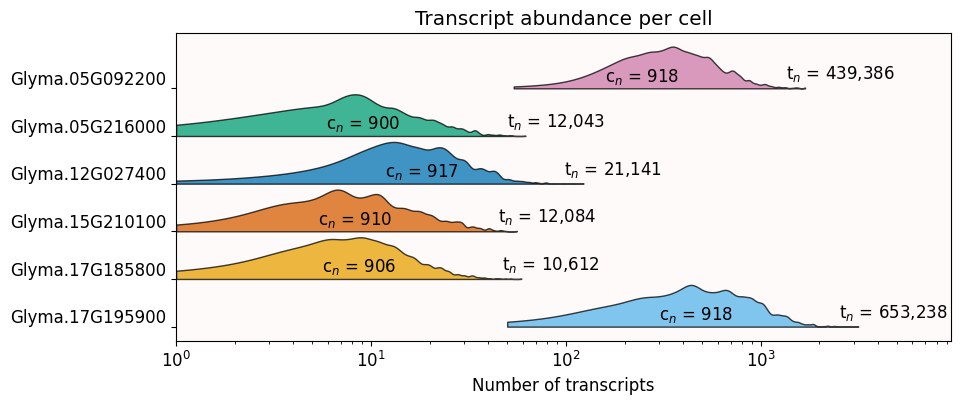

In [5]:
fs = 12
color = ['#cc79a7', '#009e73', '#0072b2', '#d55e00', '#e69f00', '#56b4e9']
cmap = ['PuBu_r', 'Greens_r', 'Blues_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r']

tnmed = 0.15*(tn.max() - tn.min()) #tn.median()


fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_facecolor('snow')
violin = ax[i].violinplot(tn.values, pos, orientation='horizontal', side='high', widths=1.75, showextrema=True, 
                          bw_method=0.1, points=1000, showmeans=False, showmedians=False);
ax[i].set_yticks(pos, [ g.replace('_','.').title() for g in tn.columns], va='bottom')
ax[i].tick_params(labelsize=fs)
ax[i].set_xlabel('Number of transcripts', fontsize=fs)
ax[i].set_title('Transcript abundance per cell', fontsize=1.2*fs)
ax[i].set_xlim(1, 3*tn.max(axis=None))
ax[i].set_xscale('log')
violin['cmaxes'].set_color('k');
violin['cmaxes'].set_lw(0)
violin['cbars'].set_lw(0)
violin['cmins'].set_lw(0)
for j in range(len(pos)):
    ax[i].text(tnmed.iloc[j], 0.05+pos[j], 'c$_n$ = {:d}'.format(tnnz.iloc[j]), ha='center', va='bottom', fontsize=fs)
    ax[i].text(0.8*tnmax.iloc[j], 0.1+pos[j], 't$_n$ = {:,}'.format(tnsum.iloc[j]), ha='left', va='bottom', fontsize=fs)

for j,pc in enumerate(violin['bodies']):
    pc.set_facecolor(color[j])
    pc.set_edgecolor('black')
    pc.set_alpha(0.75)

filename = dst + 'transcript_abundance_per_cell'
plt.savefig(filename + '.png', format='png', dpi=600, bbox_inches='tight')
plt.savefig(filename + '.pdf', format='pdf', dpi=200, bbox_inches='tight')

# Correlations

In [ ]:
smcolumns=['PC 1', 'PC 2', 'N', 'Density', 'X', 'Y', 'Cell Size', 'Eccentricity']
k = 0
vs = ['' for _ in range( len(smcolumns)*( len(smcolumns) - 1)//2) ]
for i in range(len(smcolumns)-1):
    for j in range(i+1, len(smcolumns)):
        vs[k] = '{}-vs-{}'.format(smcolumns[i] , smcolumns[j] )
        k += 1
print(vs)

In [ ]:
corrfiles = sorted( glob(isrc + '*'+level+'level/PI_scale*_corr_summary.csv') )
corrs = [None for _ in range(len(corrfiles))]
for i in range(len(corrs)):
    corrs[i] = pd.read_csv(corrfiles[i], index_col='Comparison')

exclude_nuclei = False

if exclude_nuclei:
    filenameb = '..' + os.sep + 'translocs' + os.sep + sample + os.sep + 'location_corrected_D2_-_{}.csv'
    ex_nuclei = ''
    pdkw = {'header':None, 'names':['X', 'Y', 'Z']}
else:
    filenameb = '..' + os.sep + 'Bacteria Info for Erik' + os.sep + '{}_v2.txt'
    ex_nuclei = '_w_nucleus'
    pdkw = {'sep':'\t'}

transcell = pd.read_csv(ksrc + sample + '_transcells_metadata' + ex_nuclei + '.csv', index_col='gene').rename(columns=int)
transcriptomes = np.asarray(transcell.index, dtype=str)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection' + ex_nuclei + '.csv', transcriptomes, startval=0)
transfocus = transcell.loc[ np.atleast_1d( transcriptomes[Genes[ 0 ]]), Cells]

smcolumns=['PC 1', 'PC 2', 'N', 'Density', 'X', 'Y', 'Cell Size', 'Eccentricity']
k = 0
vs = ['' for _ in range( len(smcolumns)*( len(smcolumns) - 1)//2) ]
for i in range(len(smcolumns)-1):
    for j in range(i+1, len(smcolumns)):
        vs[k] = '{}-vs-{}'.format(smcolumns[i] , smcolumns[j] )
        k += 1
print(vs)